## Previsão de cancelamento de assinatura ou serviço (churn) a fim de realizar ações preventivas
 - Projeto de Disciplina - Redes neurais com TensorFlow [25E3_2]
 - Aluna: Rosana Ribeiro Lima
 - Dataset: https://www.kaggle.com/datasets/blastchar/telco-customer-churn ou https://www.kaggle.com/datasets/ankitverma2010/ecommerce-customer-churn-analysis-and-prediction

------
### Pitch de negócio

##### Problema:

Com frequência, diversas empresas perdem receitas por cancelamento de clientes insatisfeitos, sejam empresas de telecomunicações, de streaming, bancos, entre outras. Sabe-se que o custo da aquisição de um novo cliente é maior do que o custo de manutenção dos clientes atuais (ações de marketing, campanhas, ações promocionais, etc). Mas muitas vezes, esse acompanhamento e monitoramento da saúde do relacionamento com o cliente é algo difícil.

Seria útil para as empresas se elas pudessem saber previamente quais clientes estão mais propensos ao cancelamento de um serviço, para que assim possam realizar ações preventivas mais direcionadas a esse cliente.

##### Solução proposta:
A solução proposta por este trabalho visa analisar o dataset em questão e utilizá-lo como base para criar um modelo de redes neurais que permita identificar a probabilidade de cancelamento do serviço (churn) pelo cliente, com base em dados fornecidos pela empresa. A ideia e o objetivo é treinar um modelo sensível aos clientes com tendência ao cancelamento (construir um modelo com alto recall) para então fornecer a inferência de dados por meio de uma API que a empresa possa consultar sempre que desejado (por exemplo, uma vez ao mês). Assim, sempre que a API retornar que o cliente tem alta chance de cancelamento, a empresa poderá tomar as ações que julgar necessárias para tentar evitar tal cancelamento, como o fornecimento de cupons, a entrega de brindes, entre outros. 



In [1]:
import os
import pandas as pd
import numpy as np

path = "../data/"
df = pd.read_csv(os.path.join(path, "WA_Fn-UseC_-Telco-Customer-Churn.csv"))
df.head(20)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [2]:
df.shape

(7043, 21)

In [3]:
df.info() # aqui, verificamos que não há dados nulos.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:

clientes_duplicados = df['customerID'].duplicated().any()

if clientes_duplicados:
    print("Encontrados clientes repetidos na tabela.")
else:
    print("Cada linha se refere a um cliente distinto.")

Cada linha se refere a um cliente distinto.


In [5]:
df = df.drop(['customerID'], axis=1)
df.columns


Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [6]:
print(df['gender'].value_counts())
print('-------------')
print(df['SeniorCitizen'].value_counts())
print('-------------')
print(df['Partner'].value_counts())
print('-------------')
print(df['Dependents'].value_counts())
print('-------------')
print(df['PhoneService'].value_counts())


gender
Male      3555
Female    3488
Name: count, dtype: int64
-------------
SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64
-------------
Partner
No     3641
Yes    3402
Name: count, dtype: int64
-------------
Dependents
No     4933
Yes    2110
Name: count, dtype: int64
-------------
PhoneService
Yes    6361
No      682
Name: count, dtype: int64


In [7]:
print('-------------')
print(df['MultipleLines'].value_counts())
print('-------------')
print(df['InternetService'].value_counts())
print('-------------')
print(df['OnlineSecurity'].value_counts())
print('-------------')
print(df['OnlineBackup'].value_counts())



-------------
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64
-------------
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64
-------------
OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64
-------------
OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64


In [8]:
print('-------------')
print(df['DeviceProtection'].value_counts())
print('-------------')
print(df['TechSupport'].value_counts())
print('-------------')
print(df['StreamingTV'].value_counts())
print('-------------')
print(df['StreamingMovies'].value_counts())

-------------
DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64
-------------
TechSupport
No                     3473
Yes                    2044
No internet service    1526
Name: count, dtype: int64
-------------
StreamingTV
No                     2810
Yes                    2707
No internet service    1526
Name: count, dtype: int64
-------------
StreamingMovies
No                     2785
Yes                    2732
No internet service    1526
Name: count, dtype: int64


In [9]:
print('-------------')
print(df['Contract'].value_counts())
print('-------------')
print(df['PaperlessBilling'].value_counts())
print('-------------')
print(df['PaymentMethod'].value_counts())

-------------
Contract
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64
-------------
PaperlessBilling
Yes    4171
No     2872
Name: count, dtype: int64
-------------
PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64


In [10]:
colunas_categoricas = ['gender', 'SeniorCitizen', 'Partner', 'Dependents','PhoneService',
                       'MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
                       'DeviceProtection','TechSupport','StreamingTV','StreamingMovies',
                       'Contract','PaperlessBilling','PaymentMethod']
df = pd.get_dummies(df, columns=colunas_categoricas, drop_first=False, dtype=int)


df.columns

Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn', 'gender_Female',
       'gender_Male', 'SeniorCitizen_0', 'SeniorCitizen_1', 'Partner_No',
       'Partner_Yes', 'Dependents_No', 'Dependents_Yes', 'PhoneService_No',
       'PhoneService_Yes', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',

In [11]:
df.shape

(7043, 47)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 47 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   tenure                                   7043 non-null   int64  
 1   MonthlyCharges                           7043 non-null   float64
 2   TotalCharges                             7043 non-null   object 
 3   Churn                                    7043 non-null   object 
 4   gender_Female                            7043 non-null   int64  
 5   gender_Male                              7043 non-null   int64  
 6   SeniorCitizen_0                          7043 non-null   int64  
 7   SeniorCitizen_1                          7043 non-null   int64  
 8   Partner_No                               7043 non-null   int64  
 9   Partner_Yes                              7043 non-null   int64  
 10  Dependents_No                            7043 no

In [13]:
print(type(df['TotalCharges'].loc[0]))
print(df['TotalCharges'].loc[0])


<class 'str'>
29.85


/tmp/ipykernel_167296/2343889472.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)


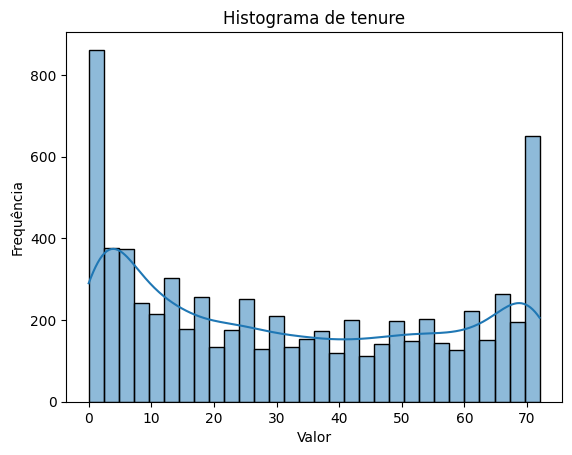

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 47 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   tenure                                   7043 non-null   int64  
 1   MonthlyCharges                           7043 non-null   float64
 2   TotalCharges                             7043 non-null   float64
 3   Churn                                    7043 non-null   object 
 4   gender_Female                            7043 non-null   int64  
 5   gender_Male                              7043 non-null   int64  
 6   SeniorCitizen_0                          7043 non-null   int64  
 7   SeniorCitizen_1                          7043 non-null   int64  
 8   Partner_No                               7043 non-null   int64  
 9   Partner_Yes                              7043 non-null   int64  
 10  Dependents_No                            7043 no

In [14]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)

import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['tenure'], bins=30, kde=True)
plt.title('Histograma de tenure')
plt.xlabel('Valor')
plt.ylabel('Frequência')
plt.show()
print(df.info())


In [15]:
df['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [16]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df['Churn'].value_counts()


Churn
0    5174
1    1869
Name: count, dtype: int64

In [17]:
df

,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,1,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1,34,56.95,1889.50,0,0,1,1,0,1,0,...,0,0,1,0,1,0,0,0,0,1
2,2,53.85,108.15,1,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
3,45,42.30,1840.75,0,0,1,1,0,1,0,...,0,0,1,0,1,0,1,0,0,0
4,2,70.70,151.65,1,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,24,84.80,1990.50,0,0,1,1,0,0,1,...,1,0,1,0,0,1,0,0,0,1
7039,72,103.20,7362.90,0,1,0,1,0,0,1,...,1,0,1,0,0,1,0,1,0,0
7040,11,29.60,346.45,0,1,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
7041,4,74.40,306.60,1,0,1,0,1,0,1,...,0,1,0,0,0,1,0,0,0,1


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight


X = df.drop('Churn', axis=1)
y = df['Churn']

# Primeiro, separe os dados de treino (70%) e um conjunto temporário (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=34, stratify=y)

# Agora, divida o conjunto temporário em validação (15%) e teste (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=34, stratify=y_temp)

print(f"Formato dos dados de treino: {X_train.shape}")
print(f"Formato dos dados de validação: {X_val.shape}")
print(f"Formato dos dados de teste: {X_test.shape}")

2025-08-02 23:41:02.529440: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-02 23:41:02.533068: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-02 23:41:02.622973: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-02 23:41:02.725827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754188862.844134  167296 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754188862.87

Formato dos dados de treino: (4930, 46)
Formato dos dados de validação: (1056, 46)
Formato dos dados de teste: (1057, 46)


In [19]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

# Ajuste o scaler com os dados de treino e transforme-os
X_train_scaled = scaler.fit_transform(X_train)

# Transforme os dados de validação e teste com o scaler já ajustado
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [20]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(2)}

In [21]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.2),  # Ajuda a prevenir overfitting
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall(name='recall')])

# Treinando o modelo com os pesos de classe
history = model.fit(X_train_scaled, y_train,
                    epochs=100,
                    batch_size=64,
                    validation_data=(X_val_scaled, y_val),
                    class_weight=class_weights,
                    verbose=1) 

Epoch 1/100


/home/rosana/.conda/envs/PD_env_redes_neurais/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-02 23:41:06.502694: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6731 - loss: 0.5993 - recall: 0.6901 - val_accuracy: 0.7197 - val_loss: 0.5253 - val_recall: 0.7643
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7433 - loss: 0.5102 - recall: 0.7740 - val_accuracy: 0.7121 - val_loss: 0.5307 - val_recall: 0.7607
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7494 - loss: 0.5043 - recall: 0.7971 - val_accuracy: 0.7225 - val_loss: 0.5202 - val_recall: 0.7429
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7519 - loss: 0.4909 - recall: 0.7773 - val_accuracy: 0.7235 - val_loss: 0.5148 - val_recall: 0.7393
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7553 - loss: 0.4886 - recall: 0.7950 - val_accuracy: 0.7453 - val_loss: 0.4830 - val_recall: 0.7250
Epoch 6/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7598 - loss: 0.4718 - recall: 0.8107 - val_accuracy: 0.7415 - val_loss: 0.4928 - val_recall: 0.7286
Epoch 7/100
78/78 ━━━━

In [22]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score

# Fazendo previsões no conjunto de teste
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int) # Convertendo probabilidades em classes (0 ou 1). 
# Como a sensibilidade para os clientes propensos ao cancelamento é importante, podemos colocar o limiar um pouco abaixo de 0.5.

# Calculando as métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Relatório de classificação completo
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acurácia: 0.7323
Precisão: 0.4976
Recall: 0.7260

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.88      0.73      0.80       776
           1       0.50      0.73      0.59       281

    accuracy                           0.73      1057
   macro avg       0.69      0.73      0.70      1057
weighted avg       0.78      0.73      0.75      1057



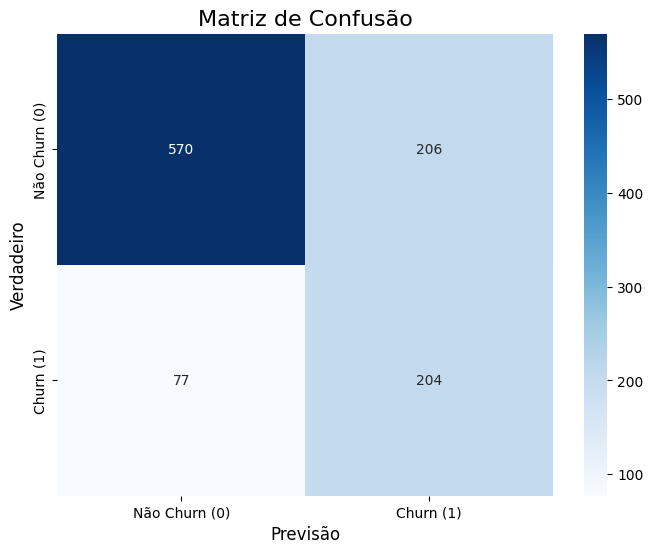

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Calcular a Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)

# 2. Criar o Gráfico (Heatmap)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Churn (0)', 'Churn (1)'],
            yticklabels=['Não Churn (0)', 'Churn (1)'])

# Adicionar títulos e rótulos para clareza
plt.title('Matriz de Confusão', fontsize=16)
plt.ylabel('Verdadeiro', fontsize=12)
plt.xlabel('Previsão', fontsize=12)
plt.show()

## Referências

